In [3]:
import numpy as np
import pandas as pd
import geopandas
import xarray as xr

from rasterio import features
from affine import Affine

import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)
rcParams['figure.figsize'] = (20,8)


In [4]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['y'], coords['x'])
    out_shape = (len(coords['y']), len(coords['x']))
    raster = features.rasterize(shapes, out_shape=out_shape, transform = transform,
                                fill=fill, all_touched = True,
                                dtype=float, **kwargs)
    
    return xr.DataArray(raster, coords=coords, dims=('y', 'x'))

In [5]:
default_shapefile_filepath = "/home/603/rp1375/Desktop/Link to Ram/Burn Mapping/03 Validation Data/Tas Fire History/fire_history_all_fires_20170907.shp"
default_reference_DataArray = xr.open_dataset('/g/data/xc0/project/Burn_Mapping/01_LS_Reflectance_and_Indices/SS/Tas2016_Sumac_Forest_reflectance.nc')

def _CreateValidatedBurnMask( shapefile_filepath = default_shapefile_filepath, 
                             reference_DataArray = default_reference_DataArray ):
    """### FUNCTION NOTES ####
    
    'shapefile_filepath' must be a file path
    'reference_DataArray' must be a xr.DataSet or xr.DataArray. i.e. it must already be opened with xr.open_dataset etc.
    
    ##########################
    """

    ############## 1) Load in the Shapefile and crop to the correct extent  ##########
    #define location of Shapefile
    df = geopandas.read_file(shapefile_filepath)

    #define projection of shapefile 
    df.crs = {'init' :'epsg:28355'}
    #Convert to same projection as the input netcdf DataArray
    df = df.to_crs({'init': 'epsg:3577'})

    #format shapefile attributes to datetime64 format
    df.IGN_DATE = df.IGN_DATE.astype('datetime64[ns]')

    x_extent = [reference_DataArray.x.min() , reference_DataArray.x.max()]
    y_extent = [reference_DataArray.y.min() , reference_DataArray.y.max()]
    df = df.cx[ x_extent[0]:x_extent[1] , y_extent[0]:y_extent[1]]


    ####OPTIONAL EXTRA CONSTRAINTS
    #crop only fires with burned area greater than 8x8 landsat pixels (i.e. 500x500 m2)
    df = df[df.SHAPE_AREA > 25*10000]
    #crop by area and timestamp
    df = df[df.IGN_DATE > '2003-01-01']
    
    
    
    ############## 2) Convert to Xarray DataArray using the coordinates from 'reference_DataArray' ##########
    try:
        del(output_array)
    except NameError:
        pass

    coords = reference_DataArray.drop('time').coords

    for date in np.unique(df.IGN_DATE):
        shapes = [(shape,1) for  n, shape in enumerate(df[df.IGN_DATE == date].geometry)]

        try:
            new_da = rasterize(shapes , coords)
            new_da = new_da.assign_coords(time = date)
            new_da = new_da.expand_dims('time')

            output_array = xr.concat((output_array,new_da), dim='time')

        except NameError:
            output_array = rasterize(shapes , coords)
            output_array = output_array.assign_coords(time = date)
            output_array = output_array.expand_dims('time')

    output_array = output_array.dropna(dim='time',how='all')
    
    return(output_array)


In [6]:
A = _CreateValidatedBurnMask()

I am densified (external_values, 7249 elements)


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


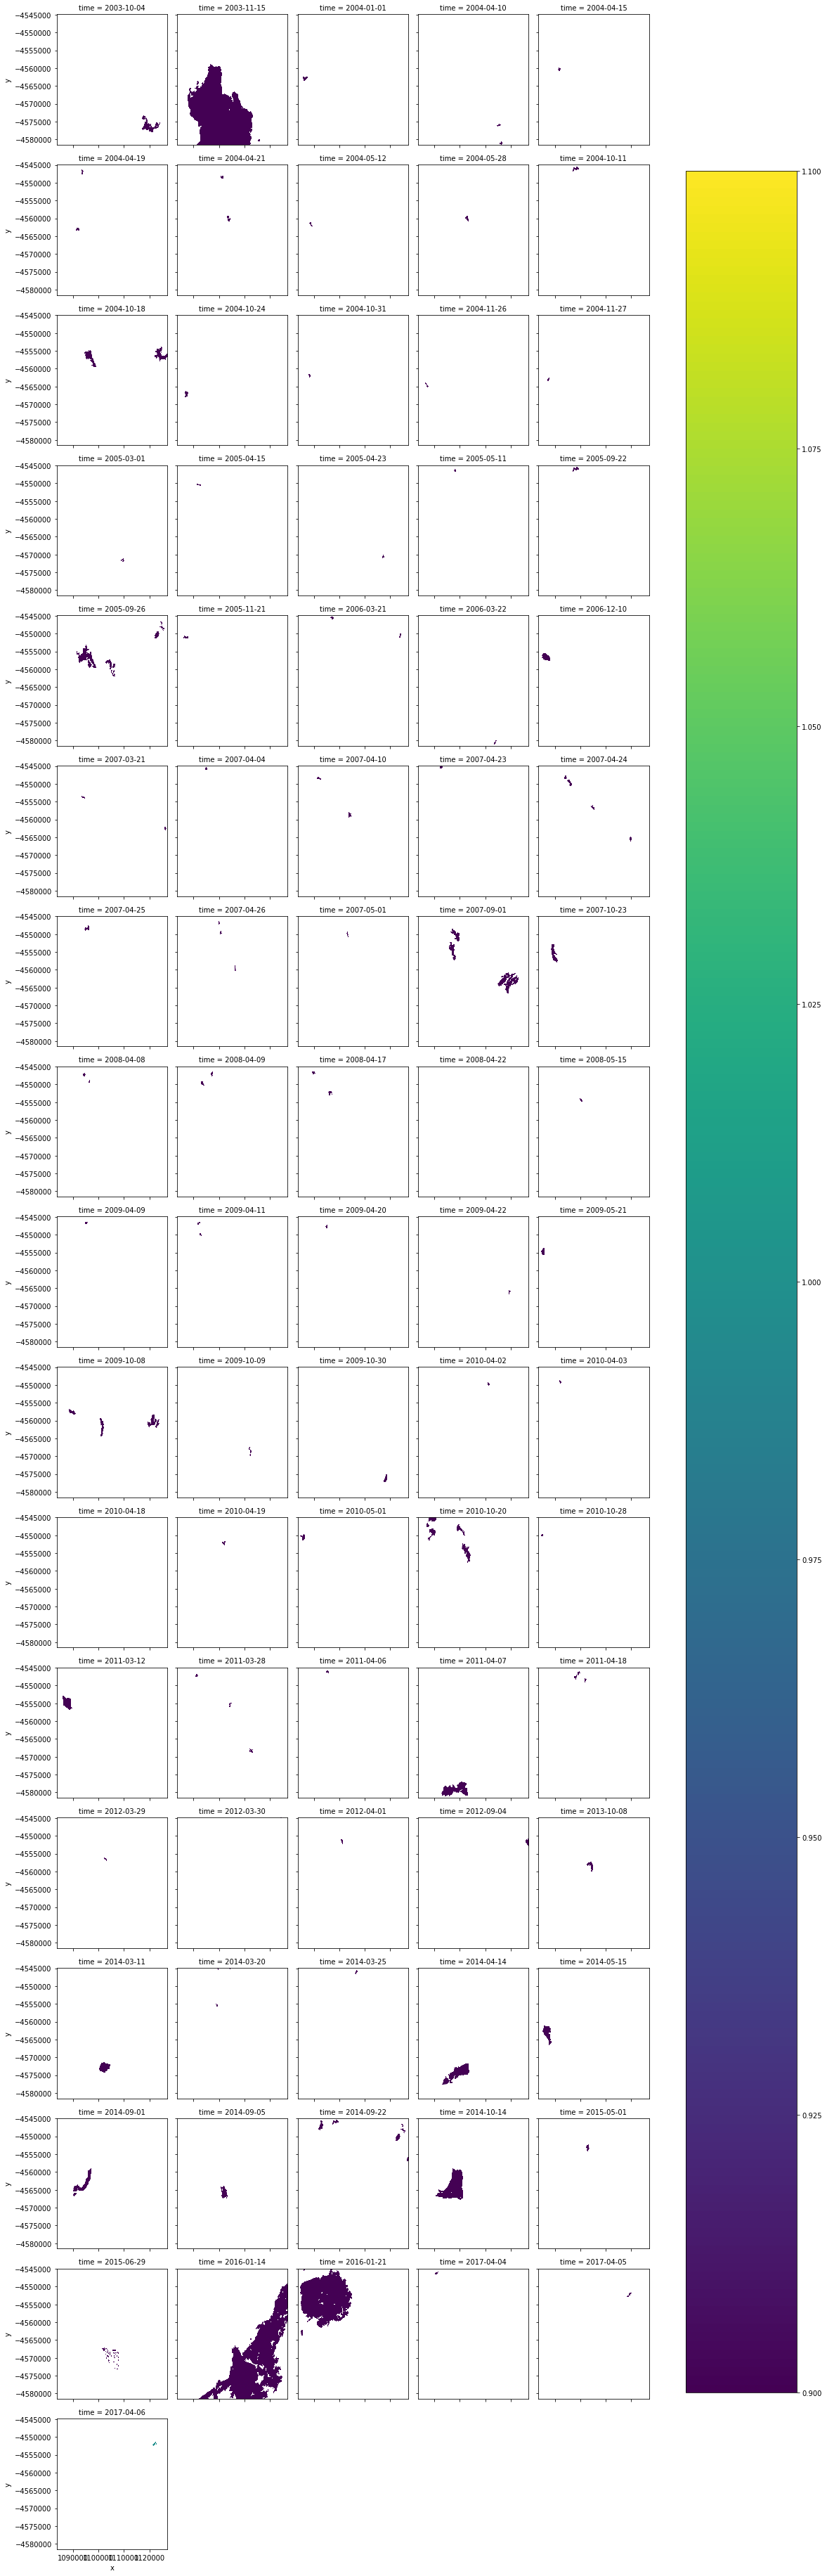

In [7]:
A.plot.imshow(col='time',col_wrap=5)